In [484]:
from sklearn.metrics import root_mean_squared_error, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, RFE, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import joblib

2024-11-29 12:33:22.275056: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Feature Engineering

First, we will load the data into our DataFrame. Sort by date and denote which Season each match corresponds to. 

In [46]:
data_dir = "finalData.csv"
df = pd.read_csv(data_dir)

In [47]:
# renaming the columns
df.columns = ['Date', 'Home Team', 'Away Team', 'Full Time Home Goals', 'Full Time Away Goals', 'Full Time Result',       
'Half Time Home Goals', 'Half Time Away Goals', 'Half Time Result', 'Referee', 'Home Shots', 'Away Shots', 'Home Shots on Target',   
'Away Shots on Target', 'Home Corners', 'Away Corners', 'Home Fouls', 'Away Fouls', 'Home Yellow Cards', 'Away Yellow Cards',     
'Home Red Cards', 'Away Red Cards', 'Home Possession', 'Away Possession', 'Home Passes Completed', 'Home Passes PCT',
'Home Progressive Passes', 'Home Progressive Passing Distance', 'Home xG', 'Home Take Ons Won', 'Home Take Ons', 
'Home Interceptions', 'Home Blocks', 'Home Touches', 'Home Touches Def 3rd', 'Home Touches Mid 3rd', 'Home Touches Att 3rd',
'Home Carries', 'Home Carries Progressive Distance', 'Home Tackles', 'Home Tackles Won', 'Away Passes Completed',
'Away Passes PCT', 'Away Progressive Passes', 'Away Progressive Passing Distance', 'Away xG',
'Away Take Ons Won', 'Away Take Ons', 'Away Interceptions', 'Away Blocks', 'Away Touches', 'Away Touches Def 3rd',
'Away Touches Mid 3rd', 'Away Touches Att 3rd', 'Away Carries', 'Away Carries Progressive Distance', 'Away Tackles',
'Away Tackles Won']

In [48]:
# ensure sorted by date
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.sort_values(by='Date')

# each season starts at 08 and ends at 05 of next year - 2000-2001 season will be the 2000 season
def get_season(date):
    if date.month >= 8:  
        return (date.year)
    else:  
        return (date.year - 1)

df['Season'] = df['Date'].apply(get_season)
df['Match Outcome'] = df['Full Time Result'].map({'H': 1, 'D': 0, 'A': -1})

Here, we begin engineering new features. The following function enables us to find the previous matches a team played (within this or the previous season). Using this key function, we created several features:

Average Goal Conversion Rate Difference, Average Attacking Intensity Difference, Average Disciplinary Pressure Difference, Recent Performances, Average Goals Scored Difference, Average Goals Conceded Difference, ...

Note: All averages use the previous RECENCY_NUM matches. If the number of previous matches in this season is too few, it will draw from the previous season as well. 

Note 2: After feature engineering, we will have to remove 101 matches that do not have RECENCY_NUM=5 matches prior. Unfortunately, this will reduce our dataset by 3.66%.

In [49]:
RECENCY_NUM = 5

In [50]:
# Team Points = total points in the game. win:3, draw:1, loss:0... DROPPED AFTERWARDS
# Total Points = cumulative sum of the team points, per team, per season
# Point Difference = difference between total points of the teams, per match
def calculate_season_points(df):
    df['Home Team Points'] = 0
    df['Away Team Points'] = 0

    for idx, row in df.iterrows():
        if row['Match Outcome'] == 1:  
            df.at[idx, 'Home Team Points'] = 3
            df.at[idx, 'Away Team Points'] = 0
        elif row['Match Outcome'] == 0: 
            df.at[idx, 'Home Team Points'] = 1
            df.at[idx, 'Away Team Points'] = 1
        elif row['Match Outcome'] == -1:  
            df.at[idx, 'Home Team Points'] = 0
            df.at[idx, 'Away Team Points'] = 3

    df['Home Total Seasonal Points'] = (df.groupby(['Home Team', 'Season'])['Home Team Points'].cumsum())
    df['Away Total Seasonal Points'] = (df.groupby(['Away Team', 'Season'])['Away Team Points'].cumsum())
    # df['Seasonal Point Difference'] = df['Home Total Seasonal Points'] - df['Away Total Seasonal Points']
    # df.drop(columns=['Home Team Points', 'Away Team Points'], inplace=True)

    return df
df = calculate_season_points(df)

In [51]:
def standardisation(df, terms=['Difference Average Goals Scored Last X Games', 'Difference Average Goals Conceded Last X Games', 'Point Difference', 'xG Difference']):
    scaler = StandardScaler()
    df[terms] = scaler.fit_transform(df[terms])
    return df

# normalises a specific set of columns
def normalisation(df, terms=['Difference Average Goals Scored Last X Games', 'Difference Average Goals Conceded Last X Games', 'Point Difference', 'xG Difference']):
    scaler = MinMaxScaler()
    df[terms] = scaler.fit_transform(df[terms])
    return df

# label encoding - use for boosting models
def label_encoding(df, col=['Home Team', 'Away Team'], dataframe=True):
    label_encoder = LabelEncoder()
    if dataframe:
        for c in col:
            df[c] = label_encoder.fit_transform(df[c])
    else:
        df = label_encoder.fit_transform(df)
    return df

Explained Variance Ratio:  [3.16576232e-01 8.45400333e-02 5.77480471e-02 4.98413595e-02
 3.97925540e-02 3.75659122e-02 3.41837323e-02 3.31313049e-02
 2.44209614e-02 2.42266364e-02 2.10247585e-02 1.90175701e-02
 1.81513320e-02 1.75881751e-02 1.65469751e-02 1.53220145e-02
 1.47904115e-02 1.39839348e-02 1.30258432e-02 1.25829526e-02
 1.18487923e-02 1.10295738e-02 1.02416566e-02 9.20479283e-03
 8.43066550e-03 7.85997645e-03 7.05260791e-03 6.22120658e-03
 5.48273633e-03 4.98185979e-03 4.62467530e-03 4.33793785e-03
 4.22584095e-03 4.05631205e-03 3.62936796e-03 3.54816995e-03
 3.00574141e-03 2.89590597e-03 2.75576708e-03 2.51615232e-03
 2.50223162e-03 2.20056031e-03 2.13312656e-03 1.82915504e-03
 1.59959876e-03 1.57101208e-03 1.52742630e-03 1.23717945e-03
 1.17426109e-03 1.06742370e-03 7.73061379e-04 2.30962891e-04
 1.20645223e-04 1.70988808e-05 2.93059148e-06 2.73610511e-06
 1.10141878e-07 8.65382054e-17]
Number of components to retain 95% variance: 31


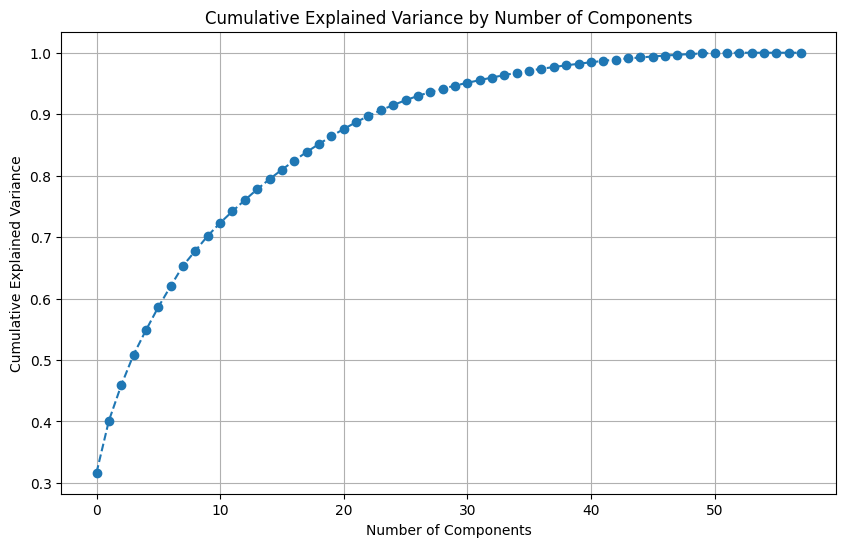

In [52]:
def pca(df):
    # drop the irrelevant terms
    featuresToDrop = ['Date', 'Home Team', 'Away Team', 'Full Time Result', 'Half Time Result', 'Referee']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    df2 = df.drop(featuresToDrop, axis=1)
    
    df2 = standardisation(df2, terms=list(df2.columns))
    
    pca = PCA()
    pca_components = pca.fit_transform(df2)
    
    # find the explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    print("Explained Variance Ratio: ", explained_variance)

    # select number of components based on explained variance (e.g., 95% variance)
    cumulative_variance = explained_variance.cumsum()
    n_components = next(i for i, v in enumerate(cumulative_variance) if v >= 0.95) + 1
    print(f"Number of components to retain 95% variance: {n_components}")

    # visualize explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_variance, marker='o', linestyle='--')
    plt.title('Cumulative Explained Variance by Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.show()
    
    return n_components
    
number_of_components = pca(df)

Next, we reduced the feature data set to 5 sections of inputs: Home Advantage, Attacking Strength, Midfield Strength, Defensive Strength, and extras. 

Discarded features include: 

'Half Time Home Goals', 'Half Time Away Goals', 'Half Time Result', 'Referee', 'Home Shots', 'Away Shots', 'Home Fouls', 'Away Fouls', 'Home Yellow Cards', 'Away Yellow Cards', 'Home Red Cards', 'Away Red Cards', 'Home Possession', 'Away Possession', 'Home Progressive Passing Distance', 'Home xG', 'Home Take Ons', 'Home Touches', 'Home Touches Def 3rd', 'Home Carries Progressive Distance', 'Away Progressive Passing Distance', 'Away xG', 'Away Take Ons', 'Away Touches', 'Away Touches Def 3rd', 'Away Carries Progressive Distance', 'Season', 'Home Team Points', 'Away Team Points', 'Home Total Seasonal Points', 'Away Total Seasonal Points'

In [53]:
features = [
    # Home Advantage
    "Home Team",
    "Away Team",
    "Match Outcome",
    "Full Time Home Goals",
    "Full Time Away Goals",
    
    # Attacking Strength
    "Home Shots on Target", "Away Shots on Target",
    "Home Progressive Passes", "Away Progressive Passes",
    "Home Touches Att 3rd", "Away Touches Att 3rd",
    "Home Take Ons Won", "Away Take Ons Won",
    "Home Corners", "Away Corners",
    
    # Midfield Strength
    "Home Touches Mid 3rd", "Away Touches Mid 3rd",
    "Home Passes Completed", "Away Passes Completed",
    "Home Passes PCT", "Away Passes PCT",
    "Home Carries", "Away Carries",
    
    # Defensive Strength
    "Home Tackles", "Away Tackles",
    "Home Tackles Won", "Away Tackles Won",
    "Home Blocks", "Away Blocks",
    "Home Interceptions", "Away Interceptions",
    
    # Extra
    "Full Time Result",
    'Date'
]

new_df = df[features].copy()
new_df.dropna(inplace=True)

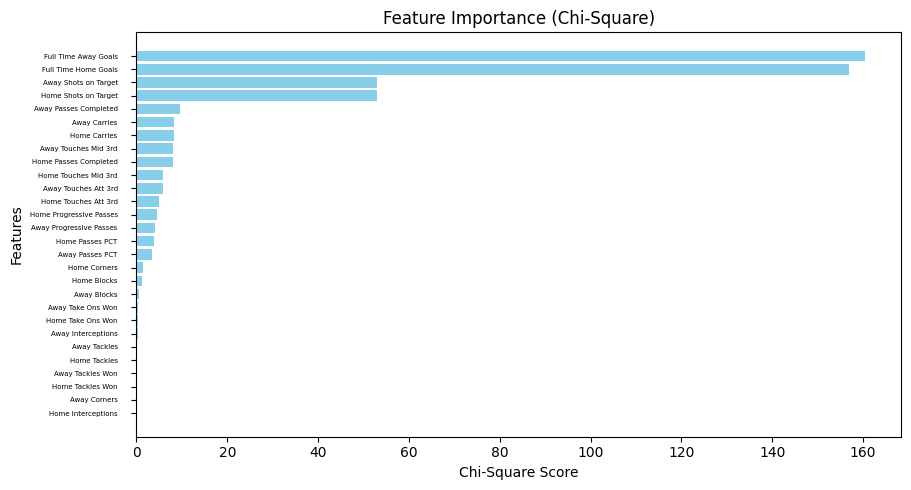

In [54]:
def chi_square(df):
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Home Team', 'Full Time Result', 'Away Team', 'Match Outcome']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    df['Match Outcome'] = df['Full Time Result'].map({'H': 1, 'D': 0, 'A': -1})
    target = df['Match Outcome']
    
    # chi2 scoring function requires non-negative input: normalisation
    data = normalisation(data, terms=list(data.columns))
    
    # collect the feature names
    feature_names = list(data.columns)
    
    # perform chi square selection    
    chi_select = SelectKBest(chi2, k=min(number_of_components, len(data.columns)))
    new_data = chi_select.fit_transform(data, target)
    
    # collect features
    selected_features = []
    for i, b in enumerate(chi_select.get_support()):
        if b:
            selected_features.append(feature_names[i])
    
    # get the chi-square scores for all features
    chi_scores = chi_select.scores_

    # create a dataFrame for easy visualization
    chi2_df = pd.DataFrame({'Feature': feature_names, 'Chi-Square Score': chi_scores})
    chi2_df = chi2_df.sort_values(by='Chi-Square Score', ascending=False)

    # plot the scores
    plt.figure(figsize=(10, 5))
    colours = ['skyblue' if i < number_of_components else 'gray' for i in range(len(chi2_df))]
    plt.barh(chi2_df['Feature'], chi2_df['Chi-Square Score'], color=colours)
    plt.xlabel('Chi-Square Score')
    plt.ylabel('Features')
    plt.title('Feature Importance (Chi-Square)')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest scores at the top
    plt.tight_layout()
    plt.tick_params(axis="y", pad=10, labelsize=5)
    plt.show()
    
    return chi2_df
    
chi2_df = chi_square(new_df)   

Now we will take the feature importance scores from the Chi-Square distribution and adjust the weights to approach a gradual steady decline. This will allow the less important features to contribute to our feature engineering later while preserving a hierarchical ranking. 

Note: the number 1/3 was chosen arbitrarily but it was observed to be a standard heuristic among Machine Learning papers.

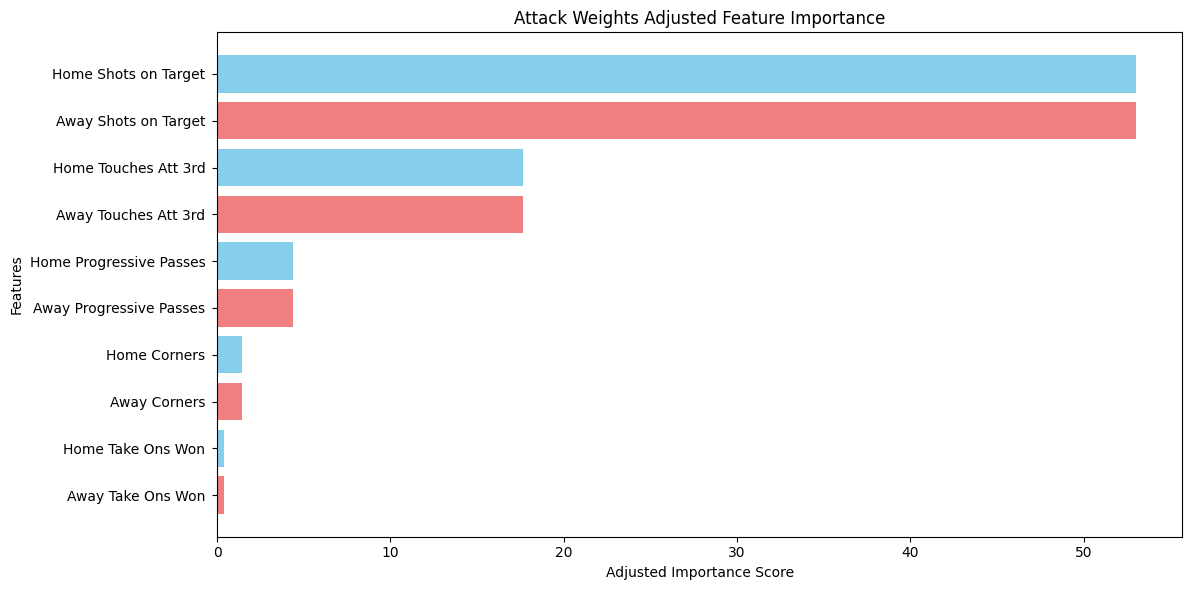

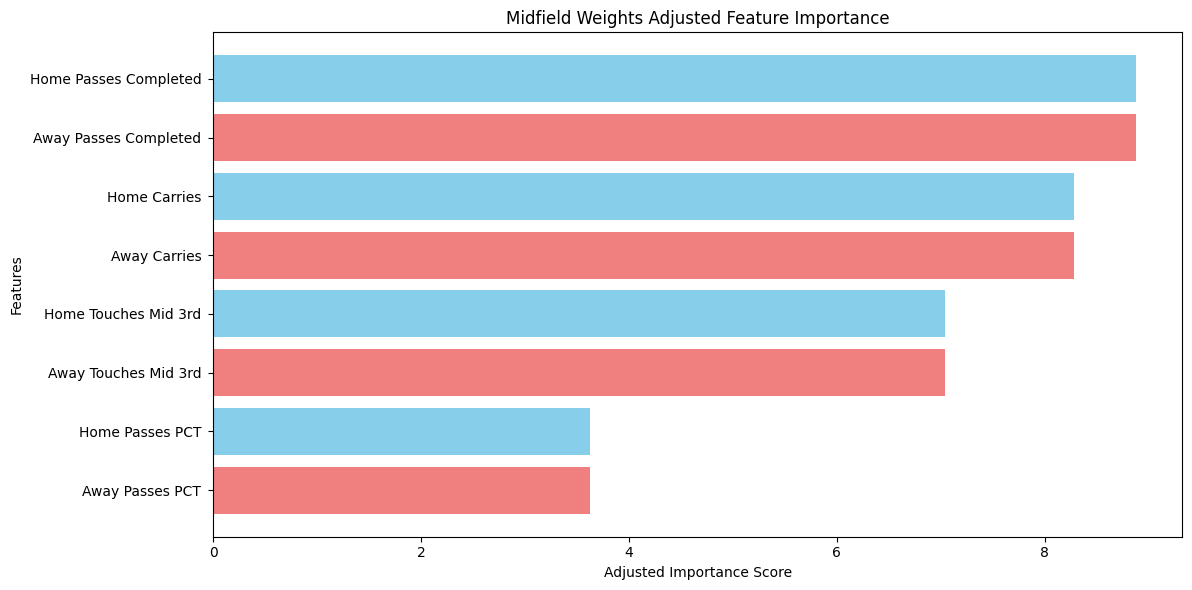

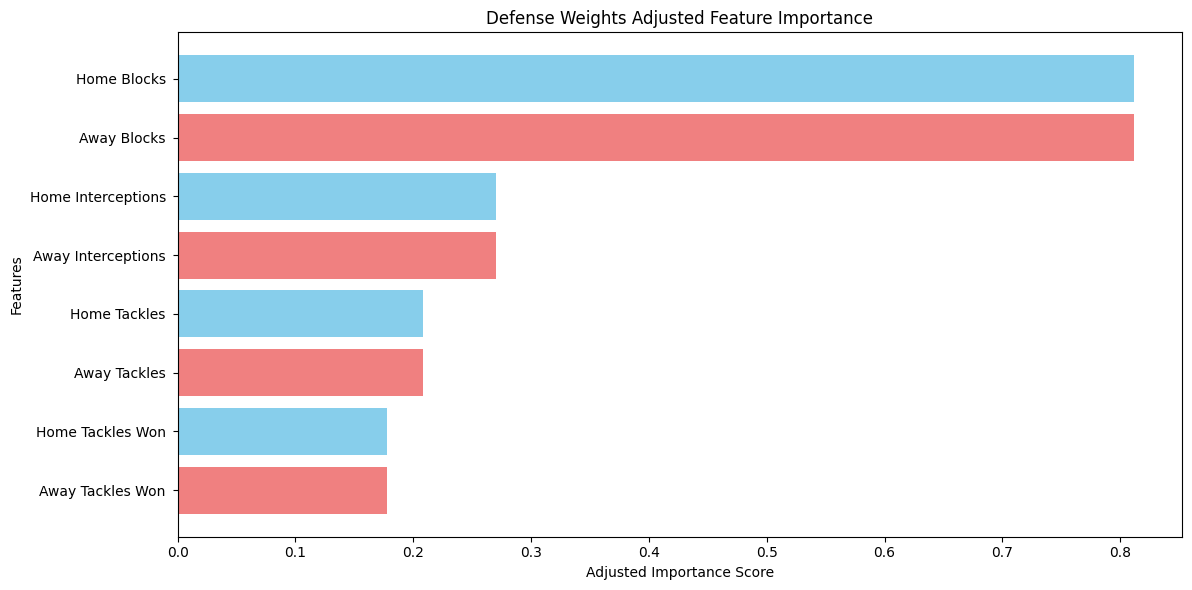

In [55]:
def adjust_feature_weights(features, chi2_df):
    # Aggregate Home and Away importance scores
    aggregated_scores = {}
    for feature_pair in features:
        home_feature, away_feature = feature_pair
        home_score = chi2_df.loc[chi2_df['Feature'] == home_feature, 'Chi-Square Score'].values[0]
        away_score = chi2_df.loc[chi2_df['Feature'] == away_feature, 'Chi-Square Score'].values[0]
        aggregated_scores[feature_pair] = home_score + away_score

    # Sort features by aggregated importance
    sorted_features = sorted(aggregated_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Adjust scores using the /3 rule
    adjusted_scores = {}
    adjusted_scores[sorted_features[0][0]] = sorted_features[0][1]  # Most important feature remains unchanged
    
    for i in range(1, len(sorted_features)):
        current_feature, current_score = sorted_features[i]
        previous_feature, previous_score = sorted_features[i - 1]
        
        if current_score < previous_score / 3:
            current_score = previous_score / 3
        adjusted_scores[current_feature] = current_score

    # Assign adjusted scores equally to Home and Away features
    final_weights = {}
    for feature_pair, score in adjusted_scores.items():
        home_feature, away_feature = feature_pair
        final_weights[home_feature] = score / 2
        final_weights[away_feature] = score / 2
    
    return final_weights

def plot_adjusted_features(weights, title):
    # prepare data for plotting
    features = list(weights.keys())
    importance = list(weights.values())

    # create the plot
    plt.figure(figsize=(12, 6))
    colours = ['skyblue' if 'Home' in feature else 'lightcoral' for feature in features]
    plt.barh(features, importance, color=colours)

    # customize the plot
    plt.xlabel('Adjusted Importance Score')
    plt.ylabel('Features')
    plt.title(title)
    plt.gca().invert_yaxis()  # highest scores at the top
    plt.tight_layout()
    plt.tick_params(axis="y", pad=5, labelsize=10)  # adjust y-axis label size for better visibility
    plt.show()


def create_strength_features_separate(df, chi2_df):
    # Define feature pairs for each group
    attack_features = [
        ("Home Shots on Target", "Away Shots on Target"),
        ("Home Progressive Passes", "Away Progressive Passes"),
        ("Home Touches Att 3rd", "Away Touches Att 3rd"),
        ("Home Take Ons Won", "Away Take Ons Won"),
        ("Home Corners", "Away Corners")
    ]
    midfield_features = [
        ("Home Touches Mid 3rd", "Away Touches Mid 3rd"),
        ("Home Passes Completed", "Away Passes Completed"),
        ("Home Passes PCT", "Away Passes PCT"),
        ("Home Carries", "Away Carries")
    ]
    defense_features = [
        ("Home Tackles", "Away Tackles"),
        ("Home Tackles Won", "Away Tackles Won"),
        ("Home Blocks", "Away Blocks"),
        ("Home Interceptions", "Away Interceptions")
    ]
    
    # Adjust weights for each group
    attack_weights = adjust_feature_weights(attack_features, chi2_df)
    midfield_weights = adjust_feature_weights(midfield_features, chi2_df)
    defense_weights = adjust_feature_weights(defense_features, chi2_df)
    
    plot_adjusted_features(attack_weights, "Attack Weights Adjusted Feature Importance")
    plot_adjusted_features(midfield_weights, "Midfield Weights Adjusted Feature Importance")
    plot_adjusted_features(defense_weights, "Defense Weights Adjusted Feature Importance")
    
    # Calculate strength scores for Home and Away
    def calculate_strength(feature_pairs, weights, team_type):
        strength_score = 0
        for home_feature, away_feature in feature_pairs:
            feature = home_feature if team_type == "Home" else away_feature
            strength_score += df[feature] * weights[feature]
        return strength_score

    # Compute Home and Away strengths for Attack, Midfield, and Defense
    df['Home Attack Strength'] = calculate_strength(attack_features, attack_weights, "Home")
    df['Away Attack Strength'] = calculate_strength(attack_features, attack_weights, "Away")
    df['Home Midfield Strength'] = calculate_strength(midfield_features, midfield_weights, "Home")
    df['Away Midfield Strength'] = calculate_strength(midfield_features, midfield_weights, "Away")
    df['Home Defense Strength'] = calculate_strength(defense_features, defense_weights, "Home")
    df['Away Defense Strength'] = calculate_strength(defense_features, defense_weights, "Away")
    
    return df



strength_df = create_strength_features_separate(new_df, chi2_df)

In [56]:
def avg_stats_last_x_games(df):
    
    def calculate_running_avg(stats_list, x):
        if len(stats_list) < x:
            return None
        return sum(stats_list[-x:]) / x

    metrics = ['Goals Scored', 'Goals Conceded', 'Attack Strength', 'Midfield Strength', 'Defense Strength', 'Recent Performance']# , 'xG', 'Disciplinary Pressure']
    for metric in metrics:
        for x in range(1, RECENCY_NUM + 1):
            df[f'Avg {metric} Home Last {x} Games'] = None
            df[f'Avg {metric} Away Last {x} Games'] = None
    running_stats = {}

    for idx, row in df.iterrows():
        for team_type in ['Home Team', 'Away Team']:
            team = row[team_type]
            stat_type = team_type.split()[0]  # Home or Away

            if team not in running_stats:
                running_stats[team] = {
                    'Goals Scored': [],
                    'Goals Conceded': [],
                    'Attack Strength': [],
                    'Midfield Strength': [],
                    'Defense Strength': [],
                    #'Disciplinary Pressure': [],
                    'Recent Performance': []
                }

            team_stats = running_stats[team]

            for x in range(1, RECENCY_NUM + 1):
                for metric in metrics:
                    avg_stat = calculate_running_avg(team_stats[metric], x)
                    df.at[idx, f'Avg {metric} {stat_type} Last {x} Games'] = avg_stat
            team_stats['Goals Scored'].append(row['Full Time Home Goals'] if stat_type == 'Home' else row['Full Time Away Goals'])
            team_stats['Goals Conceded'].append(row['Full Time Away Goals'] if stat_type == 'Home' else row['Full Time Home Goals'])
            team_stats['Attack Strength'].append(row['Home Attack Strength'] if stat_type == 'Home' else row['Away Attack Strength'])
            team_stats['Midfield Strength'].append(row['Home Midfield Strength'] if stat_type == 'Home' else row['Away Midfield Strength'])
            team_stats['Defense Strength'].append(row['Home Defense Strength'] if stat_type == 'Home' else row['Away Defense Strength'])
            #team_stats['xG'].append(row['xG Home'] if stat_type == 'Home' else row['xG Away'])
            #team_stats['Disciplinary Pressure'].append(row['Home Disciplinary Pressure'] if stat_type == 'Home' else row['Away Disciplinary Pressure'])
            team_stats['Recent Performance'].append(1 if (row['Full Time Result'] == 'H' and stat_type == 'Home') or (row['Full Time Result'] == 'A' and stat_type == 'Away') else 0.5 if row['Full Time Result'] == 'D' else 0)
    return df

df = avg_stats_last_x_games(strength_df)
df.dropna(inplace=True)    # removes the matches without enough X previous data

# Feature Selection

In [57]:
with pd.option_context('display.max_rows', 10, 'display.max_columns', None): 
    display(df)

,Home Team,Away Team,Match Outcome,Full Time Home Goals,Full Time Away Goals,Home Shots on Target,Away Shots on Target,Home Progressive Passes,Away Progressive Passes,Home Touches Att 3rd,Away Touches Att 3rd,Home Take Ons Won,Away Take Ons Won,Home Corners,Away Corners,Home Touches Mid 3rd,Away Touches Mid 3rd,Home Passes Completed,Away Passes Completed,Home Passes PCT,Away Passes PCT,Home Carries,Away Carries,Home Tackles,Away Tackles,Home Tackles Won,Away Tackles Won,Home Blocks,Away Blocks,Home Interceptions,Away Interceptions,Full Time Result,Date,Home Attack Strength,Away Attack Strength,Home Midfield Strength,Away Midfield Strength,Home Defense Strength,Away Defense Strength,Avg Goals Scored Home Last 1 Games,Avg Goals Scored Away Last 1 Games,Avg Goals Scored Home Last 2 Games,Avg Goals Scored Away Last 2 Games,Avg Goals Scored Home Last 3 Games,Avg Goals Scored Away Last 3 Games,Avg Goals Scored Home Last 4 Games,Avg Goals Scored Away Last 4 Games,Avg Goals Scored Home Last 5 Games,Avg Goals Scored Away Last 5 Games,Avg Goals Conceded Home Last 1 Games,Avg Goals Conceded Away Last 1 Games,Avg Goals Conceded Home Last 2 Games,Avg Goals Conceded Away Last 2 Games,Avg Goals Conceded Home Last 3 Games,Avg Goals Conceded Away Last 3 Games,Avg Goals Conceded Home Last 4 Games,Avg Goals Conceded Away Last 4 Games,Avg Goals Conceded Home Last 5 Games,Avg Goals Conceded Away Last 5 Games,Avg Attack Strength Home Last 1 Games,Avg Attack Strength Away Last 1 Games,Avg Attack Strength Home Last 2 Games,Avg Attack Strength Away Last 2 Games,Avg Attack Strength Home Last 3 Games,Avg Attack Strength Away Last 3 Games,Avg Attack Strength Home Last 4 Games,Avg Attack Strength Away Last 4 Games,Avg Attack Strength Home Last 5 Games,Avg Attack Strength Away Last 5 Games,Avg Midfield Strength Home Last 1 Games,Avg Midfield Strength Away Last 1 Games,Avg Midfield Strength Home Last 2 Games,Avg Midfield Strength Away Last 2 Games,Avg Midfield Strength Home Last 3 Games,Avg Midfield Strength Away Last 3 Games,Avg Midfield Strength Home Last 4 Games,Avg Midfield Strength Away Last 4 Games,Avg Midfield Strength Home Last 5 Games,Avg Midfield Strength Away Last 5 Games,Avg Defense Strength Home Last 1 Games,Avg Defense Strength Away Last 1 Games,Avg Defense Strength Home Last 2 Games,Avg Defense Strength Away Last 2 Games,Avg Defense Strength Home Last 3 Games,Avg Defense Strength Away Last 3 Games,Avg Defense Strength Home Last 4 Games,Avg Defense Strength Away Last 4 Games,Avg Defense Strength Home Last 5 Games,Avg Defense Strength Away Last 5 Games,Avg Recent Performance Home Last 1 Games,Avg Recent Performance Away Last 1 Games,Avg Recent Performance Home Last 2 Games,Avg Recent Performance Away Last 2 Games,Avg Recent Performance Home Last 3 Games,Avg Recent Performance Away Last 3 Games,Avg Recent Performance Home Last 4 Games,Avg Recent Performance Away Last 4 Games,Avg Recent Performance Home Last 5 Games,Avg Recent Performance Away Last 5 Games
57,West Ham United,Tottenham Hotspur,-1,2.0,3.0,4.0,5.0,25,46,133,110,6,9,4.0,3.0,282,282,291,323,67.8,72.3,269,281,19,19,15,13,14,12,18,9,A,2017-09-23,2680.933034,2419.274752,7040.753881,7440.516781,22.867465,18.452527,0.0,0.0,1.0,1.5,0.666667,1.333333,1.0,1.25,0.8,1.4,0.0,0.0,0.0,0.0,1.0,0.333333,1.5,0.75,2.0,0.6,2338.563864,7373.499636,2480.428027,5420.357247,2232.737788,5131.90289,2154.108463,4959.84971,2151.336594,4893.869181,9966.264294,14078.308575,7911.069366,10949.478857,8210.662851,11129.487086,7357.184523,11062.908373,7357.331228,11618.959617,8.503162,11.108236,15.674027,16.099665,15.468728,14.20933,15.062963,14.087415,16.418074,13.410971,0.5,0.5,0.75,0.75,0.5,0.666667,0.375,0.5,0.3,0.6
56,Swansea City,Watford,-1,1.0,2.0,3.0,4.0,30,30,118,103,8,12,5.0,4.0,297,305,356,364,72.7,76.5,261,335,21,17,19,7,9,9,10,12,A,2017-09-23,2386.977406,2175.049759,7674.942089,8428.667094,17.770432,15.345586,0.0,0.0,0.0,1.0,0.666667,0.666667,0.5,1.0,0.4,1.4,0.0,6.0,0.5,3.0,0.333333,2.0,1.25,1.5,1.0,1.8,

The first method of feature selection that we will look at is Recursive Feature Engineering. This (supervised) wrapper method starts with the full model. RFE then uses the model’s feature importance (model weights, coefficients) to decide which feature to remove – recursively extracting features until the desired data table is reached. 

RFE fits the data to a specific model. Here we will look at feature selection in regard to Logistic Regression. Because of this model selection, our data is standardised beforehand. 

Selected Features by RFE:
['Full Time Home Goals', 'Full Time Away Goals', 'Home Shots on Target', 'Away Shots on Target', 'Home Progressive Passes', 'Away Progressive Passes', 'Home Touches Att 3rd', 'Away Touches Mid 3rd', 'Home Passes Completed', 'Home Passes PCT', 'Away Passes PCT', 'Home Midfield Strength', 'Avg Goals Scored Away Last 1 Games', 'Avg Goals Scored Away Last 2 Games', 'Avg Goals Scored Home Last 4 Games', 'Avg Goals Scored Home Last 5 Games', 'Avg Goals Scored Away Last 5 Games', 'Avg Goals Conceded Away Last 1 Games', 'Avg Goals Conceded Away Last 2 Games', 'Avg Goals Conceded Away Last 4 Games', 'Avg Attack Strength Home Last 5 Games', 'Avg Midfield Strength Home Last 3 Games', 'Avg Midfield Strength Away Last 3 Games', 'Avg Midfield Strength Home Last 4 Games', 'Avg Midfield Strength Away Last 4 Games', 'Avg Midfield Strength Home Last 5 Games', 'Avg Defense Strength Home Last 3 Games', 'Avg Defense Strength Home Last 4 Games', 'Avg Recent Performance Away Last 1 

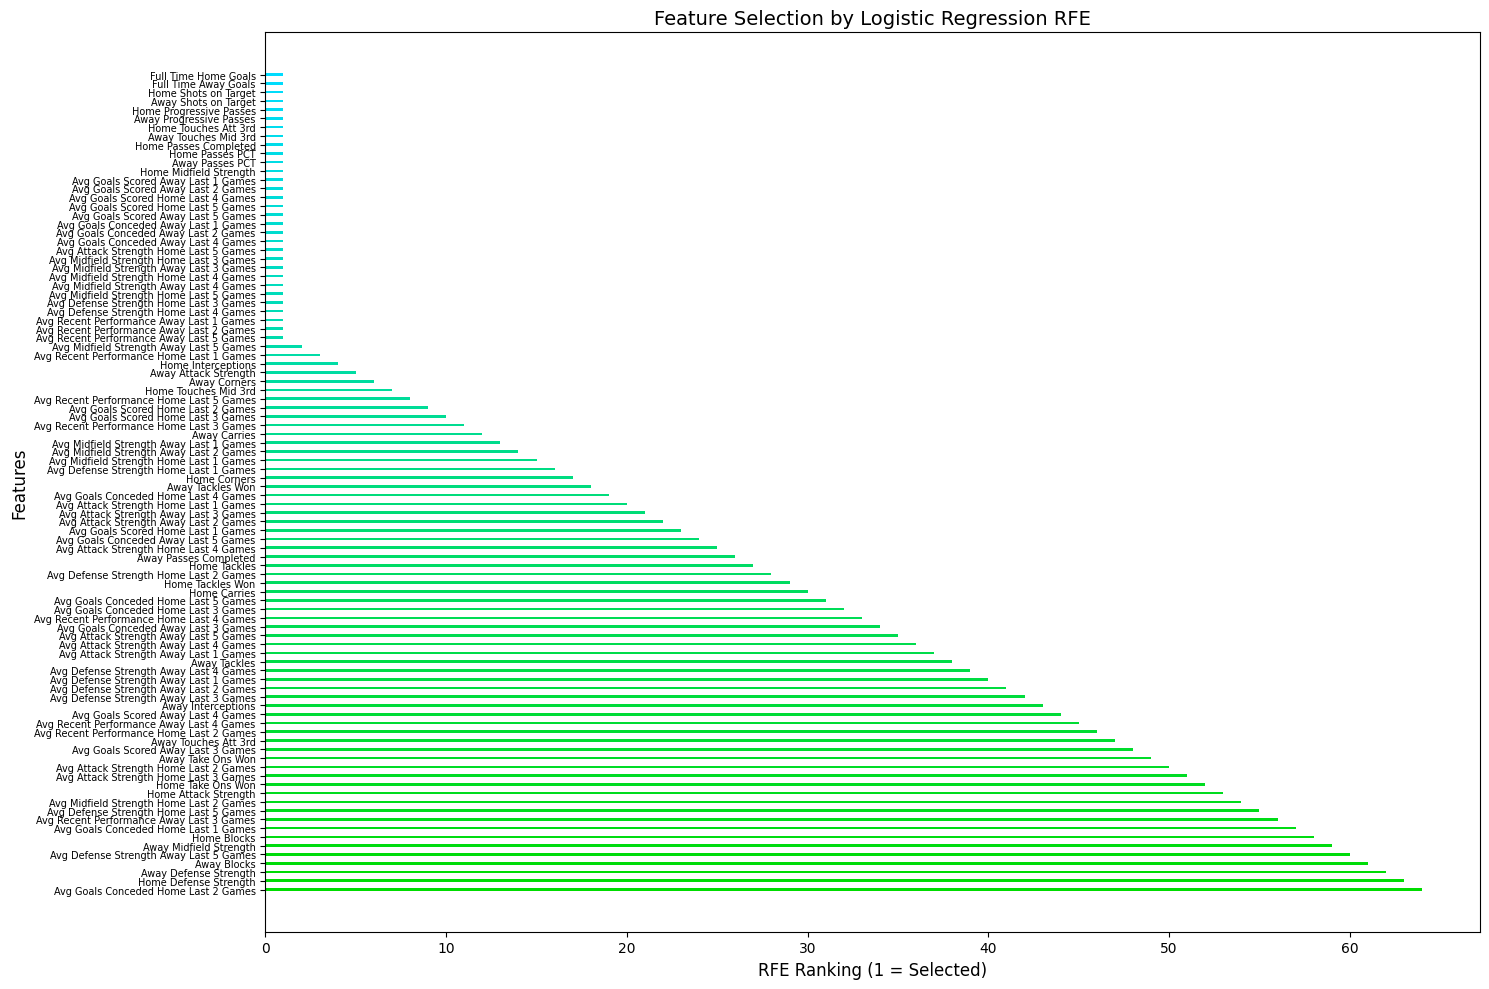

In [59]:
def recursive_feature_elimination_LR(df):
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Match Outcome', 'Home Team', 'Away Team', 'Full Time Result']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    target = df['Full Time Result']
    
    data = standardisation(data, terms=list(data.columns))
    
    # collect the feature names
    feature_names = list(data.columns)
        
    # perform RFE
    rfe = RFE(estimator=LogisticRegression(max_iter=500), n_features_to_select=number_of_components) # taken from PCA
    rfe.fit(data, target)
    
    # get feature rankings and selected features
    feature_ranking = rfe.ranking_
    selected_features = [feature for feature, rank in zip(feature_names, feature_ranking) if rank == 1]
    
    print("Selected Features by RFE (LR):")
    print(selected_features)
    
    # plot feature rankings
    plt.figure(figsize=(15, 10))
    sorted_features = sorted(zip(feature_names, feature_ranking), key=lambda x: x[1])
    sorted_names, sorted_ranks = zip(*sorted_features)

    # increase spacing between bars
    y_positions = np.arange(len(sorted_names)) * 2
    bar_height = 0.6

    # generate gradient colors from blue to green
    colors = [(0, 220/255, 1 - alpha) for alpha in np.linspace(0, 1, len(sorted_ranks))]

    # plot horizontal bar chart with gradient colors
    for ypos, rank, color in zip(y_positions, sorted_ranks, colors):
        plt.barh(ypos, rank, height=bar_height, color=color)

    plt.yticks(y_positions, sorted_names, fontsize=7)
    plt.xlabel("RFE Ranking (1 = Selected)", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.title("Feature Selection by Logistic Regression RFE", fontsize=14)

    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show() 
    
    return selected_features
            
    

logistic_features = recursive_feature_elimination_LR(df)

Next, we will look at feature selection methods for K Nearest Neighbours. As this model does not work with RFE, we will have to look at other methods. Predictions for KNN are based on the distance between data points and are therefore highly sensitive to redundant features. 

We will begin with Variance Thresholding (removing low variance features) and then apply a filter method Mutual Information (measuring non-linear relationships between the features and targets).

Variance Minimum:  0.013576172443849375  ---->  Variance Maximum:  0.19291592322287476


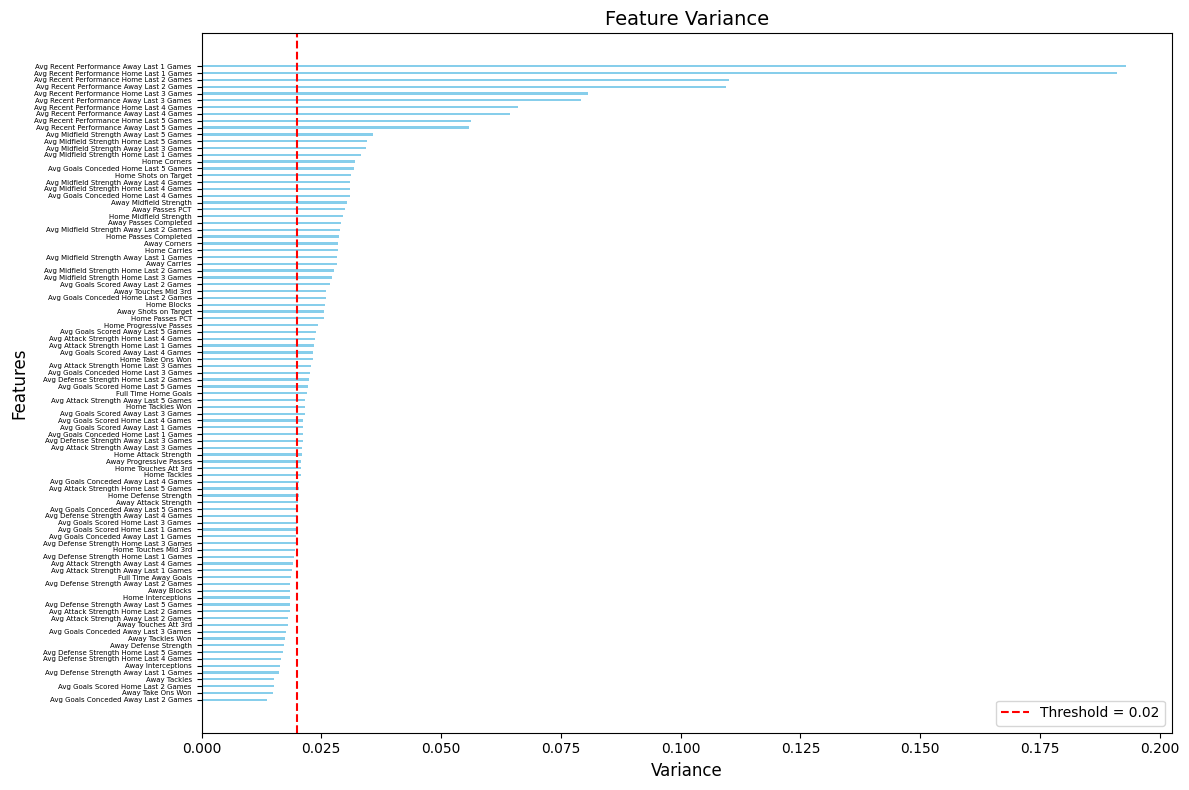

Reduced Data:  66 / 94

Removed Features and Their Variances:
---------------------------------------

Avg Defense Strength Away Last 4 Games    0.019936
Avg Goals Scored Home Last 3 Games        0.019916
Avg Goals Scored Home Last 1 Games        0.019838
Avg Goals Conceded Away Last 1 Games      0.019695
Avg Defense Strength Home Last 3 Games    0.019652
Home Touches Mid 3rd                      0.019599
Avg Defense Strength Home Last 1 Games    0.019304
Avg Attack Strength Away Last 4 Games     0.019068
Avg Attack Strength Away Last 1 Games     0.018819
Full Time Away Goals                      0.018574
Avg Defense Strength Away Last 2 Games    0.018565
Away Blocks                               0.018488
Home Interceptions                        0.018399
Avg Defense Strength Away Last 5 Games    0.018394
Avg Attack Strength Home Last 2 Games     0.018377
Avg Attack Strength Away Last 2 Games     0.018090
Away Touches Att 3rd                      0.017960
Avg Goals Conceded Away Last 3

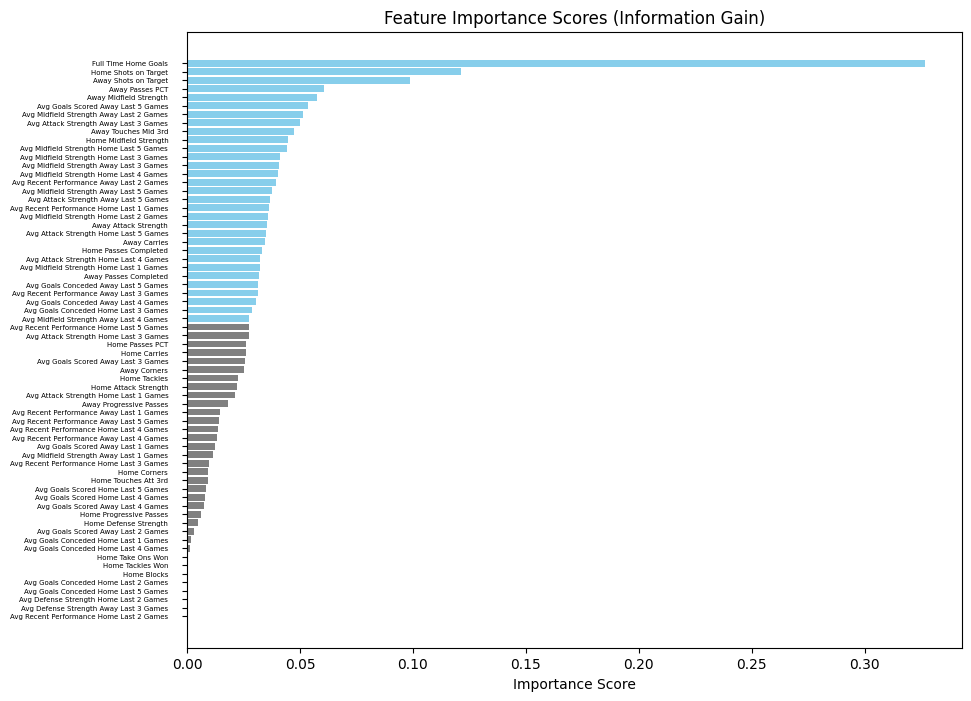


Selected Features for KNN:
['Full Time Home Goals', 'Home Shots on Target', 'Away Shots on Target', 'Away Passes PCT', 'Away Midfield Strength', 'Avg Goals Scored Away Last 5 Games', 'Avg Midfield Strength Away Last 2 Games', 'Avg Attack Strength Away Last 3 Games', 'Away Touches Mid 3rd', 'Home Midfield Strength', 'Avg Midfield Strength Home Last 5 Games', 'Avg Midfield Strength Home Last 3 Games', 'Avg Midfield Strength Away Last 3 Games', 'Avg Midfield Strength Home Last 4 Games', 'Avg Recent Performance Away Last 2 Games', 'Avg Midfield Strength Away Last 5 Games', 'Avg Attack Strength Away Last 5 Games', 'Avg Recent Performance Home Last 1 Games', 'Avg Midfield Strength Home Last 2 Games', 'Away Attack Strength', 'Avg Attack Strength Home Last 5 Games', 'Away Carries', 'Home Passes Completed', 'Avg Attack Strength Home Last 4 Games', 'Avg Midfield Strength Home Last 1 Games', 'Away Passes Completed', 'Avg Goals Conceded Away Last 5 Games', 'Avg Recent Performance Away Last 3 Game

In [523]:
def knn_feature_selection(df):
    
    # first step is calculating minimal variance features
    def variance_thresholding(data, threshold=0.02):
        variances = data.var()
        print("Variance Minimum: ", variances.min(), " ---->  Variance Maximum: ", variances.max())
    
        # filter features based on the threshold
        retained_features = variances[variances >= threshold].index
        reduced_data = data[retained_features]
        sorted_variances = variances.sort_values(ascending=False)

        # plot horizontal bar graph for feature variances
        plt.figure(figsize=(12, 8))
        y_positions = np.arange(len(sorted_variances)) * 3  # increase spacing between bars
        plt.barh(y_positions, sorted_variances, color='skyblue', height=1.0)
        plt.gca().invert_yaxis()
        
        # add a threshold line
        plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
        
        plt.yticks(y_positions, sorted_variances.index, fontsize=5)
        plt.xlabel('Variance', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.title('Feature Variance', fontsize=14)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()
        

        # print removed features and their variances
        removed_features = sorted_variances[sorted_variances < threshold]
        print("Reduced Data: ", len(reduced_data.columns), "/", len(data.columns))
        print("\nRemoved Features and Their Variances:")
        print("---------------------------------------\n")
        print(removed_features, "\n")
        
        return reduced_data
    
    # second step is mutual information between features and target
    def mutual_info(data, target):
        # apply information gain
        gain = mutual_info_regression(data, target)

        # dictionary of feature importance scores
        feature_names = list(data.columns)
        scores = {}
        for i in range(len(feature_names)):
            scores[feature_names[i]] = gain[i]

        # descending sort by importance score
        sorted_features = sorted(scores.items(), key=lambda x:x[1], reverse=True)

#         print("\nMutual Information Importance Score: ")
#         print("------------------------------------\n")
#         for feature, score in sorted_features:
#             print(f"{feature + ' score:':55}\t{score:.16f}")

        # plot a bar chat of feature importance scores
        fig, ax = plt.subplots(figsize=(10, 8))
        y_pos = np.arange(len(sorted_features))
        colours = ['skyblue' if i < number_of_components else 'gray' for i in range(len(sorted_features))]
        ax.barh(y_pos, [score for feature, score in sorted_features], align="center", color=colours)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([feature for feature, score in sorted_features])
        ax.invert_yaxis()  # Labels read top-to-bottom
        ax.set_xlabel("Importance Score")
        ax.set_title("Feature Importance Scores (Information Gain)")
        ax.tick_params(axis="y", pad=10, labelsize=5)
        plt.show()
        
        # returns most important features
        selected_features = [feature for feature, _ in sorted_features[:number_of_components]]
        print("\nSelected Features for KNN:")
        print(selected_features)
        return selected_features
        
    
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Match Outcome', 'Home Team', 'Away Team', 'Full Time Result']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    
    # normalise the data to put all the variances on the same scale
    # otherwise the difference between variances would be 0.0558 to 8728992.4427
    data = normalisation(data, terms=list(data.columns))
    
    variance_data = variance_thresholding(data)
    
    # use label encoding on the target data, keep it discrete
    target = df['Full Time Result']
    target = label_encoding(target, dataframe=False)
    
    return mutual_info(variance_data, target)
    

knn_features = knn_feature_selection(df)

Next is Recursive Feature Engineering for SVM. It will be a repeat of the last function, this time using a SVM model for feature selection. 

Selected Features by RFE (SVM):
['Full Time Home Goals', 'Full Time Away Goals', 'Away Shots on Target', 'Away Progressive Passes', 'Away Touches Att 3rd', 'Away Touches Mid 3rd', 'Home Passes Completed', 'Away Passes PCT', 'Away Carries', 'Home Tackles', 'Away Tackles', 'Home Blocks', 'Away Blocks', 'Home Interceptions', 'Away Interceptions', 'Away Attack Strength', 'Home Midfield Strength', 'Away Midfield Strength', 'Home Defense Strength', 'Away Defense Strength', 'Avg Attack Strength Home Last 3 Games', 'Avg Attack Strength Home Last 4 Games', 'Avg Attack Strength Away Last 4 Games', 'Avg Attack Strength Home Last 5 Games', 'Avg Attack Strength Away Last 5 Games', 'Avg Midfield Strength Home Last 3 Games', 'Avg Midfield Strength Away Last 3 Games', 'Avg Midfield Strength Home Last 4 Games', 'Avg Midfield Strength Away Last 4 Games', 'Avg Midfield Strength Home Last 5 Games', 'Avg Midfield Strength Away Last 5 Games']


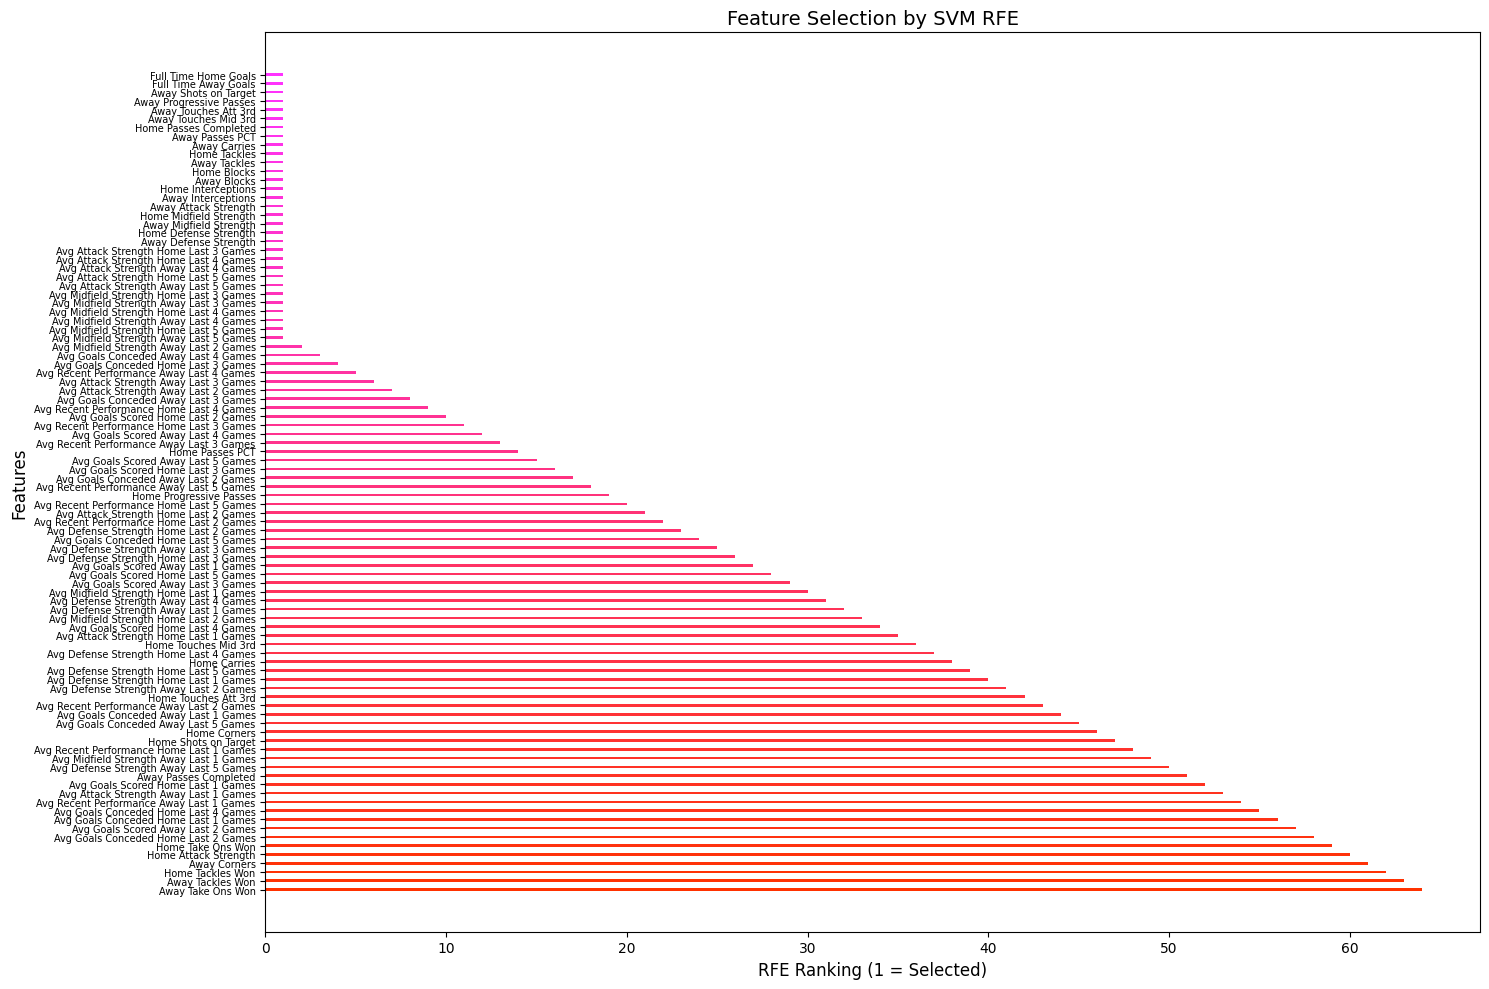

In [514]:
def recursive_feature_elimination_svm(df):
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Match Outcome', 'Home Team', 'Away Team', 'Full Time Result']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    target = df['Full Time Result']
    
    data = standardisation(data, terms=list(data.columns))
    
    # collect the feature names
    feature_names = list(data.columns)
        
    # perform RFE
    rfe = RFE(estimator=SVC(kernel="linear"), n_features_to_select=number_of_components) # taken from PCA
    rfe.fit(data, target)
    
    # get feature rankings and selected features
    feature_ranking = rfe.ranking_
    selected_features = [feature for feature, rank in zip(feature_names, feature_ranking) if rank == 1]
    
    print("Selected Features by RFE (SVM):")
    print(selected_features)
    
    # plot feature rankings
    plt.figure(figsize=(15, 10))
    sorted_features = sorted(zip(feature_names, feature_ranking), key=lambda x: x[1])
    sorted_names, sorted_ranks = zip(*sorted_features)

    # increase spacing between bars
    y_positions = np.arange(len(sorted_names)) * 2
    bar_height = 0.6

    # generate gradient colors from blue to green
    colors = [(1, 50/255, 1 - alpha) for alpha in np.linspace(0, 1, len(sorted_ranks))]

    # plot horizontal bar chart with gradient colors
    for ypos, rank, color in zip(y_positions, sorted_ranks, colors):
        plt.barh(ypos, rank, height=bar_height, color=color)

    plt.yticks(y_positions, sorted_names, fontsize=7)
    plt.xlabel("RFE Ranking (1 = Selected)", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.title("Feature Selection by SVM RFE", fontsize=14)

    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return selected_features
            
    
svm_features = recursive_feature_elimination_svm(df)

Interesting to notice here that RFE using a Logistic Regression model reveals the same set of features as RFE using a SVM model. 

For data to be used by an LSTM model, we must consider temporal dependencies during feature selection. First we will apply Mutual Information. MI measures the dependency between data and targets, capturing both linear and nonlinear relationships. LSTMs are sensitive to noise, so we should remove irrelevant features by using MI. We will then use RFE with a tree based model to rank the rest of the features. Tree based models excel at identifying patterns, which is useful for LSTMs. This allows the LSTM to focus on high-signal features. 

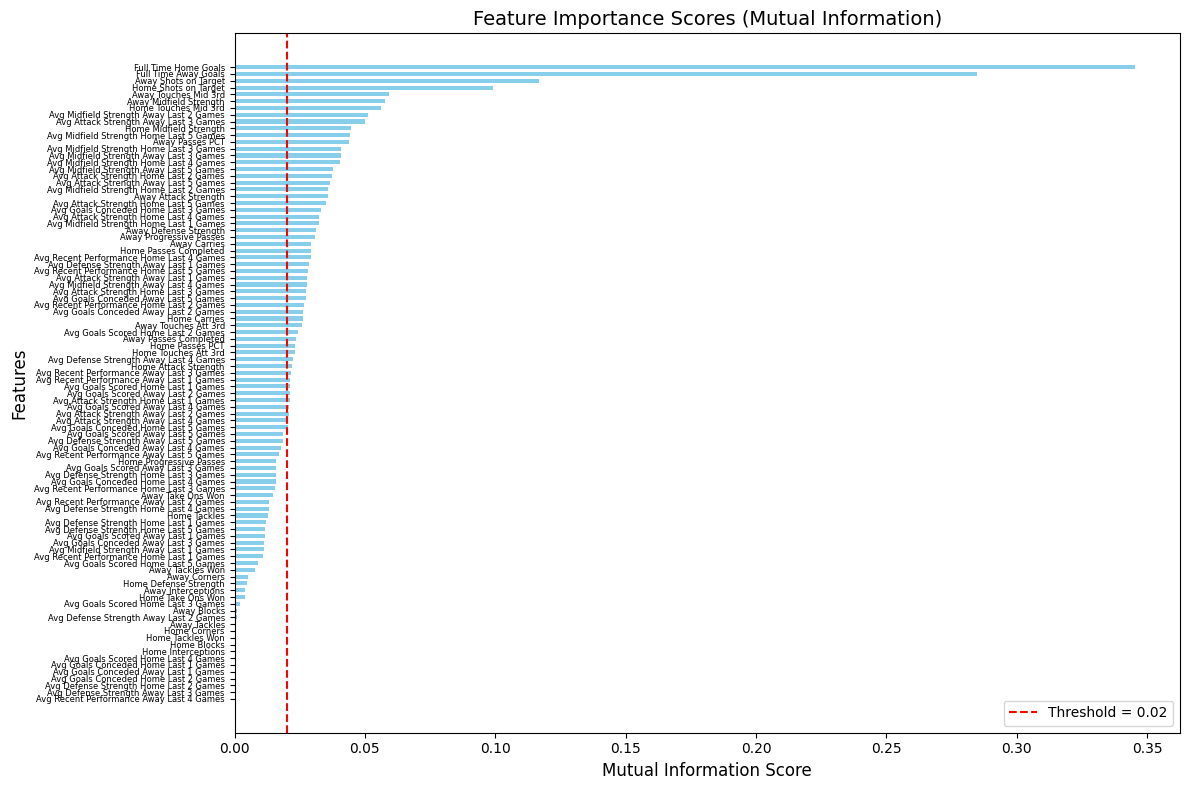


Selected Features based on Mutual Information Threshold: 54 / 94


In [527]:
def lstm_feature_selection(df):
    # first applies mutual information and removes the redundant features
    def mutual_info(data, target, threshold=0.02):
        gain = mutual_info_regression(data, target)

        # dictionary of feature importance scores
        feature_names = list(data.columns)
        scores = {}
        for i in range(len(feature_names)):
            scores[feature_names[i]] = gain[i]

        # sort features by importance score in descending order
        sorted_features = sorted(scores.items(), key=lambda x: x[1], reverse=True)

        # plot a bar chart of feature importance scores
        fig, ax = plt.subplots(figsize=(12, 8))
        y_pos = np.arange(len(sorted_features))
        ax.barh(y_pos, [score for _, score in sorted_features], align="center", color="skyblue", height=0.6)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([feature for feature, _ in sorted_features], fontsize=6)
        ax.invert_yaxis()
        ax.set_xlabel("Mutual Information Score", fontsize=12)
        ax.set_ylabel("Features", fontsize=12)
        ax.set_title("Feature Importance Scores (Mutual Information)", fontsize=14)
        plt.axvline(x=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # filter features based on the threshold
        selected_features = [feature for feature, score in sorted_features if score >= threshold]
        print("\nSelected Features based on Mutual Information Threshold:", len(selected_features), "/", len(data.columns))

        return data[selected_features]
    
    
    
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Match Outcome', 'Home Team', 'Away Team', 'Full Time Result']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    
    # use label encoding on the target data, keep it discrete
    target = df['Full Time Result']
    target = label_encoding(target, dataframe=False)
    
    reduced_data = mutual_info(data, target)
    
lstm_feature_selection(df)

In [39]:
def chronological_split(df, train_ratio=0.8, chronological=False):
    df = df.sort_values(by='Date')
    df.drop(columns=['Date'], inplace=True)
    df.dropna(inplace=True)
    if chronological:
        train_size = int(len(df) * train_ratio)
        train_df = df[:train_size]
        test_df = df[train_size:]
    else:
        train_df, test_df = train_test_split(df, train_size=train_ratio, random_state=31, shuffle=True)
    return train_df, test_df

def encode_teams(df, encoding="one-hot"):
    if encoding == "one-hot":
        encoder = OneHotEncoder()
        encoded_teams = encoder.fit_transform(df[['Home Team']]).toarray()
        encoded_team_columns = encoder.get_feature_names_out(['Home Team'])
        
        encoded_df = pd.DataFrame(encoded_teams, columns=encoded_team_columns, index=df.index)
        df = pd.concat([df, encoded_df], axis=1)
        return df.drop(['Home Team'], axis=1)
    else:
        teams = df['Home Team'].unique()        
        encoder = LabelEncoder()
        encoder.fit(teams)
        
        df['Home Team'] = encoder.transform(df['Home Team'])
        
        return df
    
def standardize_features(df, features, scale_type='minmax'):
    if scale_type == 'minmax':
        scaler = MinMaxScaler()
    else: 
        scaler = StandardScaler()
    
    df[features] = scaler.fit_transform(df[features])
    return df

In [40]:
class RecencyModelTrainingNew:
    def __init__(self):
        pass

    def train_with_iterations(self, X_train, y_train, X_test, y_test, iterations):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        for max_iter in iterations:
            model = LogisticRegression(
                multi_class='multinomial', solver='lbfgs', max_iter=max_iter,
                random_state=31
            )
            model.fit(X_train, y_train)

            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)

            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics

    def train_and_evaluate_knn(self, X_train, y_train, X_test, y_test, neighbors_range):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        for n_neighbors in neighbors_range:
            knn = KNeighborsClassifier(n_neighbors=n_neighbors)
            knn.fit(X_train, y_train)

            train_predictions = knn.predict(X_train)
            test_predictions = knn.predict(X_test)

            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics

    def train_and_evaluate_svm(self, X_train, y_train, X_test, y_test):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        svm = SVC(kernel='linear', random_state=31)
        svm.fit(X_train, y_train)

        train_predictions = svm.predict(X_train)
        test_predictions = svm.predict(X_test)

        self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics


    def train_and_evaluate_lstm(self, X_train, y_train, X_test, y_test, epochs=10):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        # One-hot encode the target labels for multi-class classification
        # Since target variable is int (0, 1, 2), we use to_categorical to one-hot encode it
        y_train_one_hot = to_categorical(y_train, num_classes=3)
        y_test_one_hot = to_categorical(y_test, num_classes=3)

        # Reshape data for LSTM [samples, time steps, features]
        X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

        # Define the LSTM model
        lstm_model = Sequential([
            LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
            LSTM(64, return_sequences=False),
            Dense(3, activation='softmax')  # For multi-class classification (3 classes)
        ])
        
        # Compile the model with categorical crossentropy for multi-class classification
        lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Train the model
        lstm_model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=32, verbose=1)

        # Predict probabilities for each class
        train_predictions = lstm_model.predict(X_train)
        test_predictions = lstm_model.predict(X_test)

        # Convert probabilities to class predictions (0, 1, or 2)
        train_predictions = train_predictions.argmax(axis=1)  # Select the class with the highest probability
        test_predictions = test_predictions.argmax(axis=1)

        # Compute metrics for multi-class classification
        self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics

    def _compute_metrics(self, metrics, train_predictions, test_predictions, y_train, y_test):
        train_accuracy = accuracy_score(y_train, train_predictions)
        test_accuracy = accuracy_score(y_test, test_predictions)

        metrics['train_accuracy'].append(train_accuracy)
        metrics['test_accuracy'].append(test_accuracy)

        metrics['train_rmse'].append(np.sqrt(np.mean((y_train - train_predictions) ** 2)))
        metrics['test_rmse'].append(np.sqrt(np.mean((y_test - test_predictions) ** 2)))

        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            y_train, train_predictions, average='weighted'
        )
        test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
            y_test, test_predictions, average='weighted'
        )

        metrics['train_precision'].append(train_precision)
        metrics['test_precision'].append(test_precision)
        metrics['train_recall'].append(train_recall)
        metrics['test_recall'].append(test_recall)
        metrics['train_f1'].append(train_f1)
        metrics['test_f1'].append(test_f1)

    def plot_metrics(self, metrics, model_name, iterations=None, neighbors_range=None):
        metric_keys = list(metrics.keys())
        n_metrics = len(metric_keys)

        plt.figure(figsize=(15, 10))
        for i, key in enumerate(metric_keys, 1):
            plt.subplot((n_metrics + 1) // 2, 2, i)

            # Print the metric data for debugging
            print(f"Plotting Metric: {key}")
            print(f"Metric Data: {metrics[key]}")  # Print the actual metrics data for inspection
            
            if iterations is not None:
                print(f"Iterations: {iterations}")
                # Ensure that iterations and metrics match in length
                if len(metrics[key]) != len(iterations):
                    print(f"Warning: Length mismatch between iterations and {key} metric")
                plt.plot(iterations, metrics[key], label=key, marker='o')
                x_vals = iterations
            elif neighbors_range is not None:
                print(f"Neighbors Range: {neighbors_range}")
                # Ensure that neighbors_range and metrics match in length
                if len(metrics[key]) != len(neighbors_range):
                    print(f"Warning: Length mismatch between neighbors_range and {key} metric")
                plt.plot(neighbors_range, metrics[key], label=key, marker='o')
                x_vals = neighbors_range
            else:
                plt.plot(metrics[key], label=key, marker='o')
                x_vals = range(len(metrics[key]))  # Default x-values if neither is provided

            # Check if there are multiple values to plot
            if len(x_vals) > 1:
                for x, y in zip(x_vals, metrics[key]):
                    plt.text(x, y, f'{y:.2f}', fontsize=8, ha='center', va='bottom')
            else:
                print(f"Warning: Only one data point for {key}. This may indicate an issue with data collection.")

            plt.xlabel('Iterations' if iterations is not None else 'Number of Neighbors')
            plt.ylabel(f'{key}')
            plt.title(f'{model_name} - {key} over Iterations' if iterations is not None else f'{model_name} - {key} over Neighbors')
            plt.grid()

        plt.tight_layout()
        plt.show()

    def save_model(self, filename):
        joblib.dump(self.model, filename)

    def load_model(self, filename):
        self.model = joblib.load(filename)


In [41]:
features = [
    'Avg Goals Scored Home Last 1 Games',
       'Avg Goals Scored Away Last 1 Games',
       'Avg Goals Scored Home Last 2 Games',
       'Avg Goals Scored Away Last 2 Games',
       'Avg Goals Scored Home Last 3 Games',
       'Avg Goals Scored Away Last 3 Games',
       'Avg Goals Scored Home Last 4 Games',
       'Avg Goals Scored Away Last 4 Games',
       'Avg Goals Scored Home Last 5 Games',
       'Avg Goals Scored Away Last 5 Games',
       'Avg Goals Conceded Home Last 1 Games',
       'Avg Goals Conceded Away Last 1 Games',
       'Avg Goals Conceded Home Last 2 Games',
       'Avg Goals Conceded Away Last 2 Games',
       'Avg Goals Conceded Home Last 3 Games',
       'Avg Goals Conceded Away Last 3 Games',
       'Avg Goals Conceded Home Last 4 Games',
       'Avg Goals Conceded Away Last 4 Games',
       'Avg Goals Conceded Home Last 5 Games',
       'Avg Goals Conceded Away Last 5 Games',
       'Avg Attack Strength Home Last 1 Games',
       'Avg Attack Strength Away Last 1 Games',
       'Avg Attack Strength Home Last 2 Games',
       'Avg Attack Strength Away Last 2 Games',
       'Avg Attack Strength Home Last 3 Games',
       'Avg Attack Strength Away Last 3 Games',
       'Avg Attack Strength Home Last 4 Games',
       'Avg Attack Strength Away Last 4 Games',
       'Avg Attack Strength Home Last 5 Games',
       'Avg Attack Strength Away Last 5 Games',
       'Avg Midfield Strength Home Last 1 Games',
       'Avg Midfield Strength Away Last 1 Games',
       'Avg Midfield Strength Home Last 2 Games',
       'Avg Midfield Strength Away Last 2 Games',
       'Avg Midfield Strength Home Last 3 Games',
       'Avg Midfield Strength Away Last 3 Games',
       'Avg Midfield Strength Home Last 4 Games',
       'Avg Midfield Strength Away Last 4 Games',
       'Avg Midfield Strength Home Last 5 Games',
       'Avg Midfield Strength Away Last 5 Games',
       'Avg Defense Strength Home Last 1 Games',
       'Avg Defense Strength Away Last 1 Games',
       'Avg Defense Strength Home Last 2 Games',
       'Avg Defense Strength Away Last 2 Games',
       'Avg Defense Strength Home Last 3 Games',
       'Avg Defense Strength Away Last 3 Games',
       'Avg Defense Strength Home Last 4 Games',
       'Avg Defense Strength Away Last 4 Games',
       'Avg Defense Strength Home Last 5 Games',
       'Avg Defense Strength Away Last 5 Games',
       'Avg Recent Performance Home Last 1 Games',
       'Avg Recent Performance Away Last 1 Games',
       'Avg Recent Performance Home Last 2 Games',
       'Avg Recent Performance Away Last 2 Games',
       'Avg Recent Performance Home Last 3 Games',
       'Avg Recent Performance Away Last 3 Games',
       'Avg Recent Performance Home Last 4 Games',
       'Avg Recent Performance Away Last 4 Games',
       'Avg Recent Performance Home Last 5 Games',
       'Avg Recent Performance Away Last 5 Games',
       'Home Team',
       'Match Outcome',
       'Date'
]
df = df[features]

In [42]:
print('Preprocessing Data...')
df = encode_teams(df)
numerical_features = [col for col in df.columns if 'Avg' in col]
df = standardize_features(df, numerical_features)

train_df, test_df = chronological_split(df)

X_train, y_train = train_df.drop('Match Outcome', axis=1), train_df['Match Outcome']
X_test, y_test = test_df.drop('Match Outcome', axis=1), test_df['Match Outcome']

Preprocessing Data...


In [43]:
# Model Training
print('Starting Training...')
trainer = RecencyModelTrainingNew()

iterations = np.arange(0, 200, 10)
neighbors_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]

metrics_logistic = trainer.train_with_iterations(X_train, y_train, X_test, y_test, iterations)
metrics_knn = trainer.train_and_evaluate_knn(X_train, y_train, X_test, y_test, neighbors_range)
metrics_svm = trainer.train_and_evaluate_svm(X_train, y_train, X_test, y_test)
metrics_lstm = trainer.train_and_evaluate_lstm(X_train, y_train, X_test, y_test, epochs=10)

Starting Training...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: Und

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: Futu

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4493 - loss: 1.0626
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5295 - loss: 0.9838
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5505 - loss: 0.9533
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5517 - loss: 0.9444
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5362 - loss: 0.9616
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5545 - loss: 0.9432
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5673 - loss: 0.9243
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5645 - loss: 0.9232
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5652 - loss: 0.9300
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5562 - loss: 0.9365
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

Plotting Metric: train_accuracy
Metric Data: [0.45347744360902253, 0.5502819548872181, 0.5718984962406015, 0.5714285714285714, 0.5700187969924813, 0.5700187969924813, 0.5737781954887218, 0.5718984962406015, 0.5733082706766918, 0.5728383458646616, 0.5733082706766918, 0.5737781954887218, 0.5737781954887218, 0.5737781954887218, 0.5737781954887218, 0.5737781954887218, 0.5737781954887218, 0.5737781954887218, 0.5737781954887218, 0.5737781954887218]
Iterations: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190]
Plotting Metric: test_accuracy
Metric Data: [0.42105263157894735, 0.5338345864661654, 0.5338345864661654, 0.5300751879699248, 0.5375939849624061, 0.5394736842105263, 0.5357142857142857, 0.5375939849624061, 0.5375939849624061, 0.5394736842105263, 0.5394736842105263, 0.5394736842105263, 0.5394736842105263, 0.5394736842105263, 0.5394736842105263, 0.5394736842105263, 0.5394736842105263, 0.5394736842105263, 0.5394736842105263, 0.5394736842105263]
Iterations: 

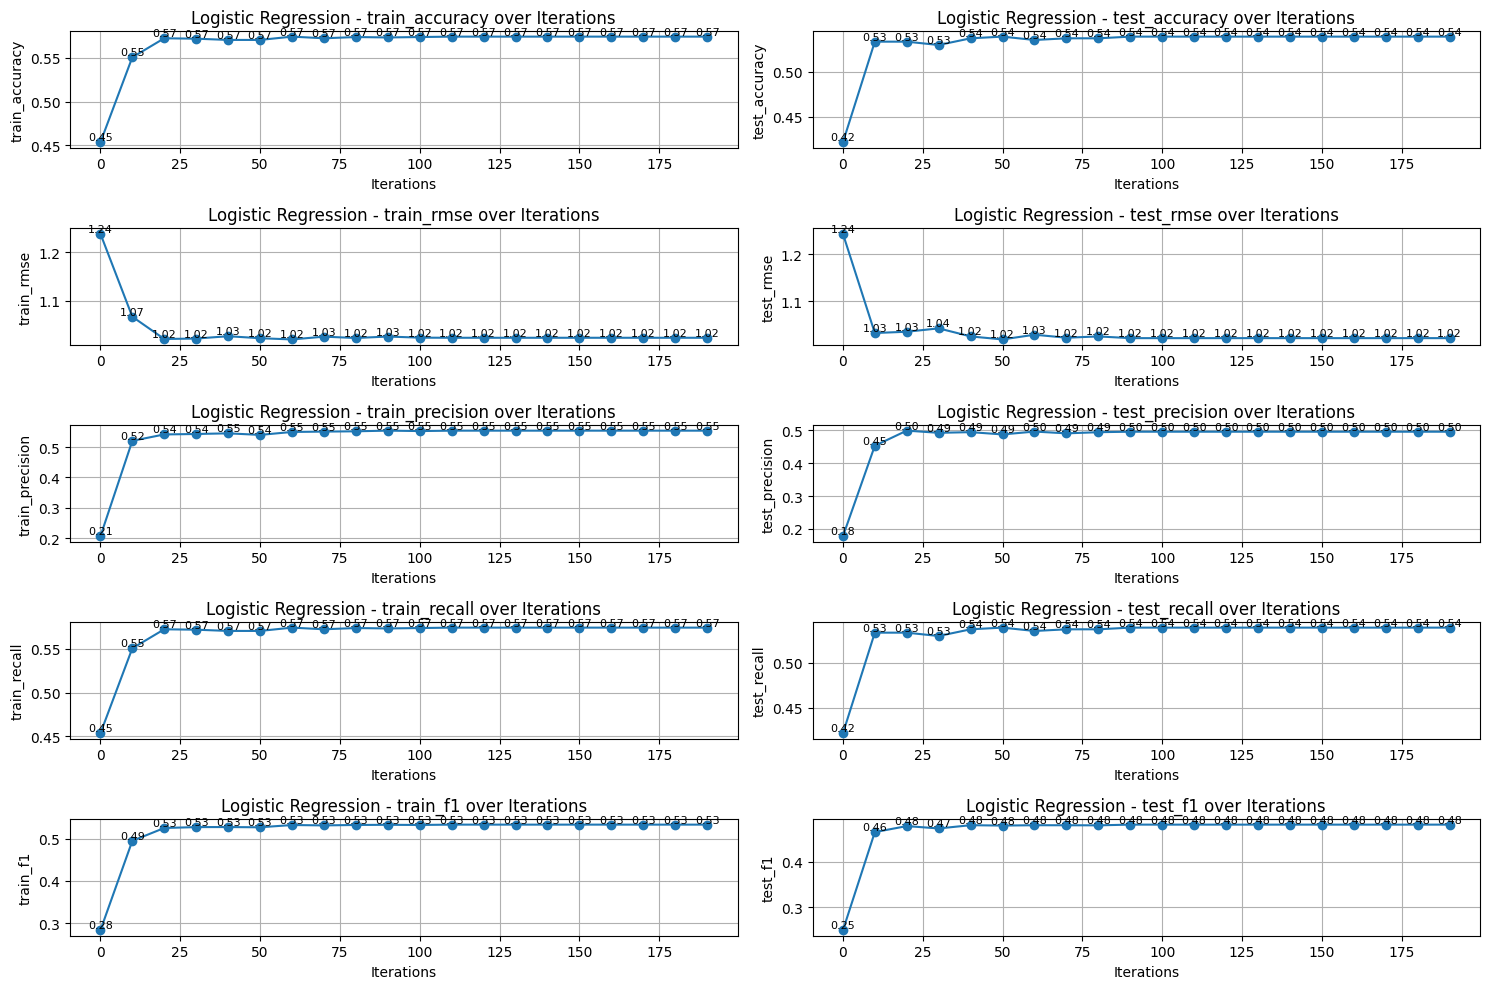

Plotting Metric: train_accuracy
Metric Data: [1.0, 0.6954887218045113, 0.6461466165413534, 0.6146616541353384, 0.6015037593984962, 0.5939849624060151, 0.5972744360902256, 0.5888157894736842, 0.5892857142857143, 0.5770676691729323, 0.5841165413533834, 0.5770676691729323, 0.5728383458646616, 0.5765977443609023, 0.5714285714285714, 0.5615601503759399, 0.5667293233082706, 0.5648496240601504, 0.5620300751879699, 0.5625, 0.5648496240601504, 0.5601503759398496, 0.5596804511278195, 0.5535714285714286, 0.5526315789473685, 0.5512218045112782]
Neighbors Range: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]
Plotting Metric: test_accuracy
Metric Data: [0.42105263157894735, 0.4718045112781955, 0.45300751879699247, 0.4830827067669173, 0.4868421052631579, 0.5056390977443609, 0.5112781954887218, 0.5112781954887218, 0.5, 0.4943609022556391, 0.4981203007518797, 0.5169172932330827, 0.5206766917293233, 0.5169172932330827, 0.5225563909774437, 0.5263157894

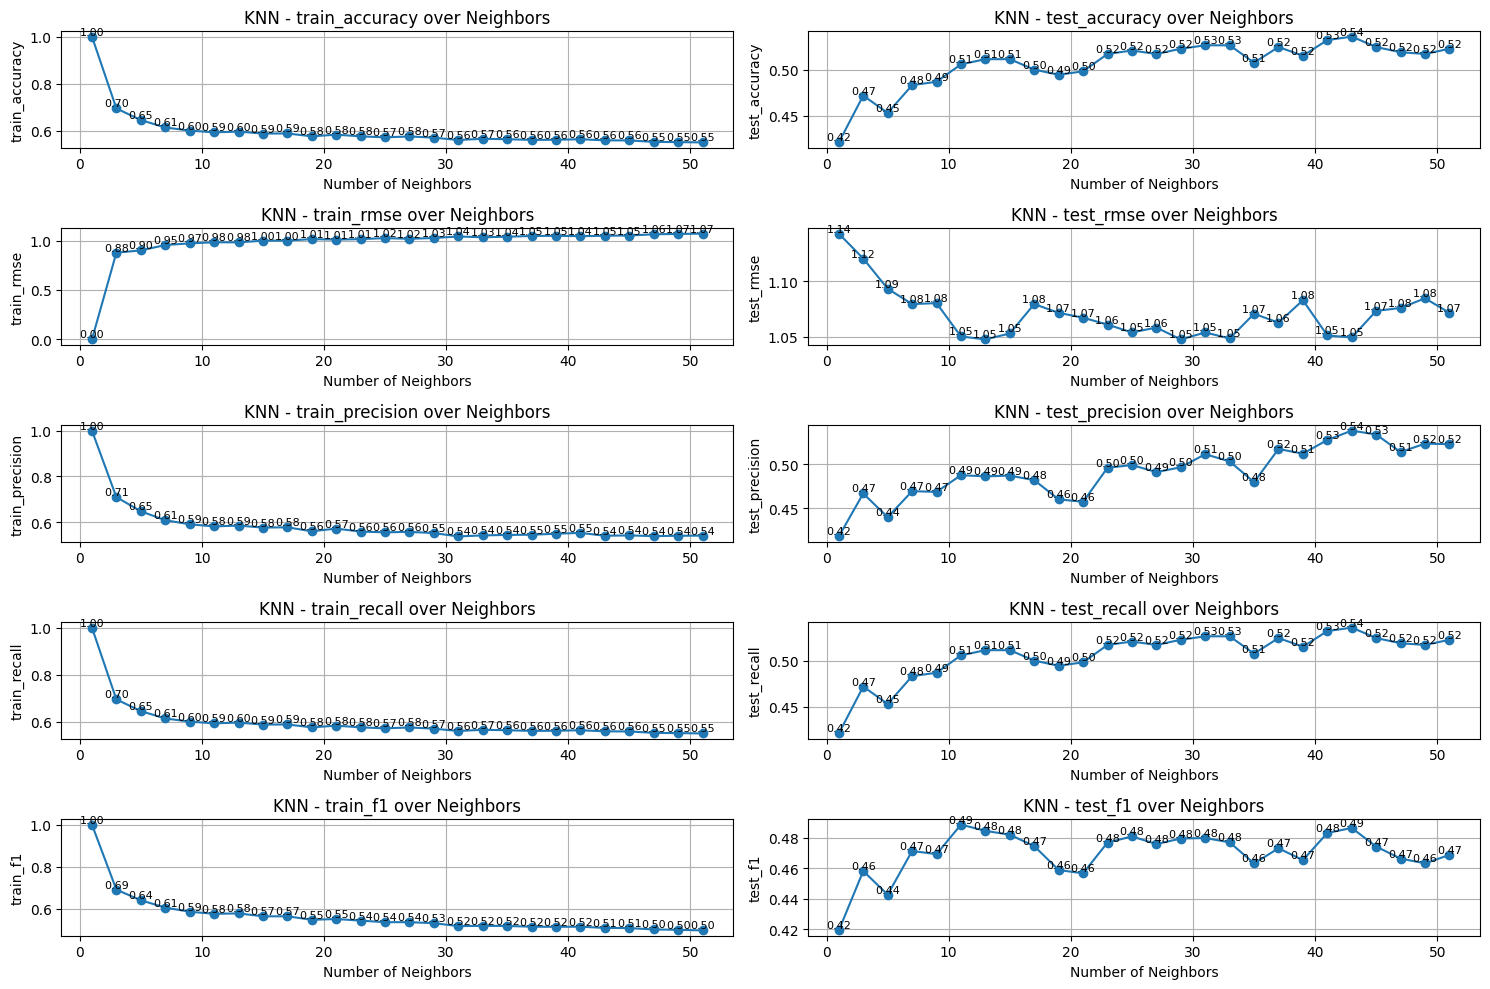

Plotting Metric: train_accuracy
Metric Data: [0.5718984962406015]
Plotting Metric: test_accuracy
Metric Data: [0.5375939849624061]
Plotting Metric: train_rmse
Metric Data: [1.021847802919215]
Plotting Metric: test_rmse
Metric Data: [1.0241446091500594]
Plotting Metric: train_precision
Metric Data: [0.547987419155052]
Plotting Metric: test_precision
Metric Data: [0.5086385867079016]
Plotting Metric: train_recall
Metric Data: [0.5718984962406015]
Plotting Metric: test_recall
Metric Data: [0.5375939849624061]
Plotting Metric: train_f1
Metric Data: [0.5315745993322917]
Plotting Metric: test_f1
Metric Data: [0.48870635769073434]


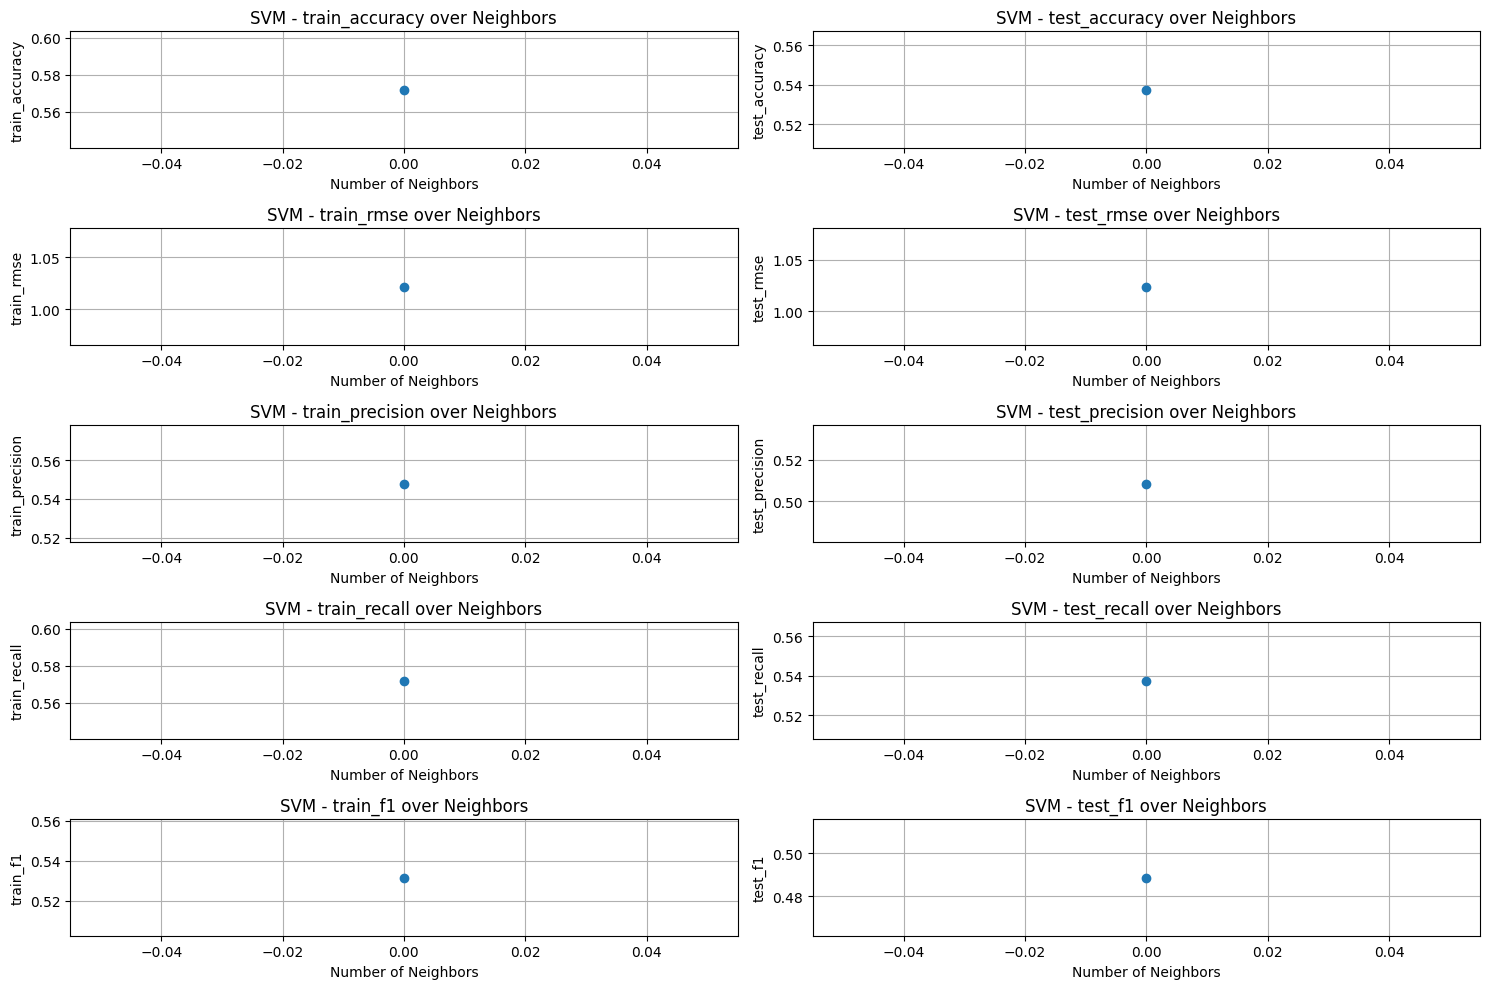

Plotting Metric: train_accuracy
Metric Data: [0.3618421052631579]
Plotting Metric: test_accuracy
Metric Data: [0.325187969924812]
Plotting Metric: train_rmse
Metric Data: [1.7155579552275]
Plotting Metric: test_rmse
Metric Data: [1.7439476435543146]
Plotting Metric: train_precision
Metric Data: [0.37931265257676167]
Plotting Metric: test_precision
Metric Data: [0.29365079365079366]
Plotting Metric: train_recall
Metric Data: [0.3618421052631579]
Plotting Metric: test_recall
Metric Data: [0.325187969924812]
Plotting Metric: train_f1
Metric Data: [0.3246675727916806]
Plotting Metric: test_f1
Metric Data: [0.2797793857684965]


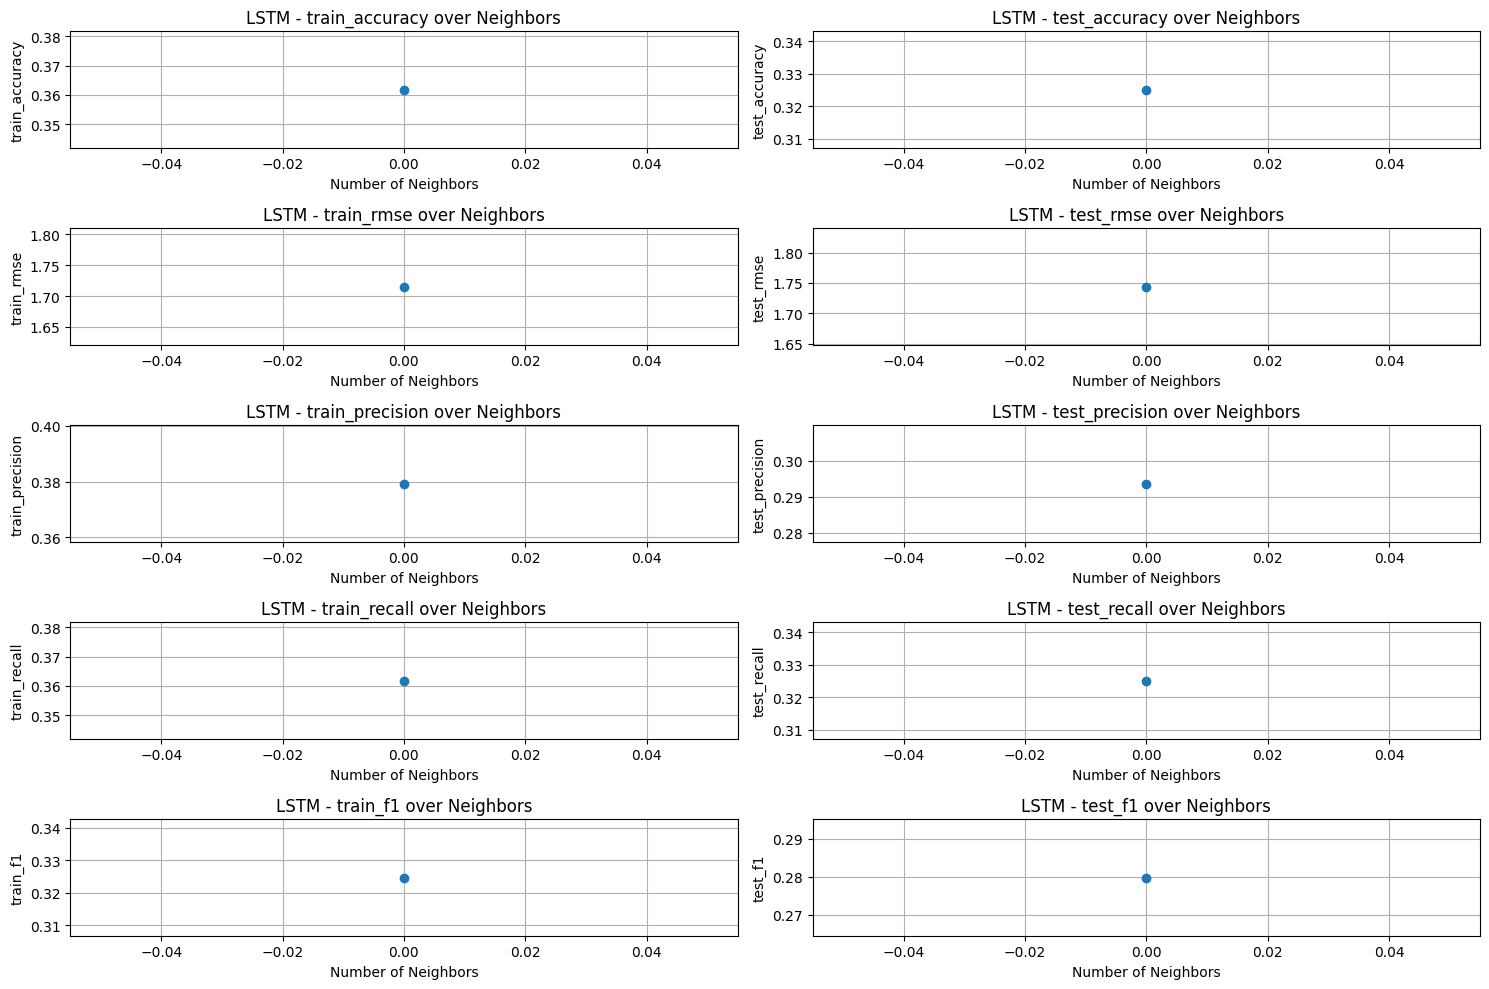

In [44]:
# Plotting Metrics for all Models
trainer.plot_metrics(metrics_logistic, "Logistic Regression", iterations=iterations)
trainer.plot_metrics(metrics_knn, "KNN", neighbors_range=neighbors_range)
trainer.plot_metrics(metrics_svm, "SVM")
trainer.plot_metrics(metrics_lstm, "LSTM")